In [1]:
%matplotlib inline

In [16]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
from hcp_utils import load_hcp
from plotting import plot_surf_stat_map, crop_img
import cmocean
import nibabel as nb

In [54]:
def brain_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(12,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

### Comparing Myelin map and FC1

In [3]:
myelin_file='/nobackup/ilz3/myelinconnect/hcp/data/myelin.npy'
embed_file='/nobackup/ilz3/myelinconnect/hcp/data/gradients.npy'
myelin = np.load(myelin_file)
gradients = np.load(embed_file)

In [4]:
stats.pearsonr(myelin, -gradients[:,0])

(0.52408499, 0.0)

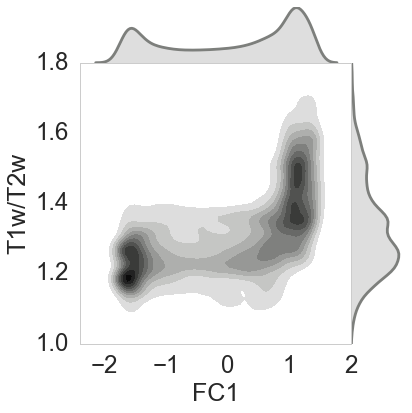

In [27]:
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.5)

xlim = (-2.4, 2)
ylim = (1, 1.8)
xticks = [-2, -1,0,1,2]
yticks = [1.0, 1.2,1.4, 1.6,1.8]
scatter_color = sns.xkcd_rgb['medium grey']
fig = sns.jointplot(-gradients[:,0],myelin,
                    stat_func=None,space=0,ylim=ylim,xlim=xlim,
                    kind="kde", size=6, color=scatter_color, n_levels=10, shade=True, shade_lowest=False)
fig.set_axis_labels('FC1', 'T1w/T2w', fontsize=25)
fig.ax_joint.set_yticks(yticks);
fig.ax_joint.set_xticks(xticks);
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/HCP_FC1_myelin.png')
sns.set()

### Finding best combined model

In [6]:
model_df = pd.read_csv('/nobackup/ilz3/myelinconnect/hcp/results/model_comparison_20maps.csv')
len_maps = [len(eval(model_df['maps'][i])) for i in range(len(model_df['maps']))]

In [8]:
model_df['maplen'] = len_maps
min_models = model_df.groupby('maplen').aggregate({'BIC':np.min})
maps=[]
for i in range(1,21):
    maps.append(model_df.loc[np.where(model_df['BIC'] == min_models.loc[i]['BIC'])[0][0]]['maps'])
min_models['maps']=maps

In [9]:
min_models.loc[min_models['BIC'].idxmin()]

BIC                  335.822
maps    (0, 3, 4, 8, 10, 19)
Name: 6, dtype: object

In [47]:
min_models 

,BIC,maps
maplen,,
1,492.897550,"(0,)"
2,403.284878,"(0, 4)"
3,384.216021,"(0, 2, 4)"
4,370.932980,"(0, 3, 4, 7)"
5,355.005989,"(0, 3, 4, 8, 10)"
6,335.822000,"(0, 3, 4, 8, 10, 19)"
7,340.881584,"(0, 3, 4, 8, 10, 17, 19)"
8,344.675960,"(0, 3, 4, 8, 10, 11, 17, 19)"
9,351.151003,"(0, 3, 4, 8, 10, 13, 15, 16, 19)"


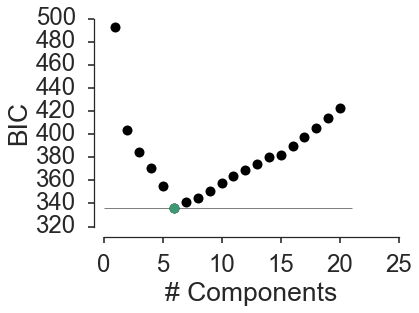

In [11]:
sns.set_style('ticks')
sns.set_context('poster', font_scale=1.5)
fig=plt.figure(figsize=(6.5,5))
plt.plot(min_models['BIC'], color='black', linewidth=0, marker=".", markersize=20)
plt.plot(min_models['BIC'].idxmin(), min_models['BIC'].min(), color=sns.xkcd_rgb['ocean green'],
        markersize=20, marker='.')

plt.xlabel('# Components')
plt.ylabel('BIC')
#plt.yticks([320, 500])
#plt.xticks([1,3,6,9,12,15])
plt.hlines(min_models['BIC'].min(), 0, 21, linestyle='-', linewidth=1, colors='black',alpha=0.5)

sns.despine(offset=10, trim=True)
fig.tight_layout()
#fig.savefig(pic_folder+'bic_models.svg')
sns.set()

#min_models.to_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/min_models.csv')

### Comparison in high dimensional space

In [12]:
fc_t1_corr = np.load('/nobackup/ilz3/myelinconnect/hcp/results/matrix_comparison/fc_myelin_corr.npy' )

In [19]:
surfL, surfR, cortL, cortR = load_hcp('/nobackup/ilz3/myelinconnect/hcp/surfaces/')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [47]:
lh_fc_t1_corr_recort = np.zeros((surfL[0].shape[0]))
lh_fc_t1_corr_recort[cortL] = fc_t1_corr[:cortL.shape[0]]
rh_fc_t1_corr_recort = np.zeros((surfR[0].shape[0]))
rh_fc_t1_corr_recort[cortR] = fc_t1_corr[cortL.shape[0]:]

In [87]:
sulcL = np.zeros(len(surfL[0]))
sulcR = np.zeros(len(surfR[0]))
sulcL[cortL] = -1 * nb.load('/nobackup/ilz3/myelinconnect/hcp/surfaces/S900.sulc_MSMAll.32k_fs_LR.dscalar.nii').get_data().squeeze()[:len(cortL)]
sulcR[cortR] = -1 * nb.load('/nobackup/ilz3/myelinconnect/hcp/surfaces/S900.sulc_MSMAll.32k_fs_LR.dscalar.nii').get_data().squeeze()[len(cortL):]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [164]:
sns.set_context(None)
cropped_img = []
cmap=cmocean.cm.ice

sns.set_style('white')
for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfL[0], surfL[1], stat_map=lh_fc_t1_corr_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcL, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False, vmin=-0.6, vmax=0.4)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfR[0], surfR[1], stat_map=rh_fc_t1_corr_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcR, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False , vmin=-0.6, vmax=0.4)
    cropped_img.append(crop_img(plot))

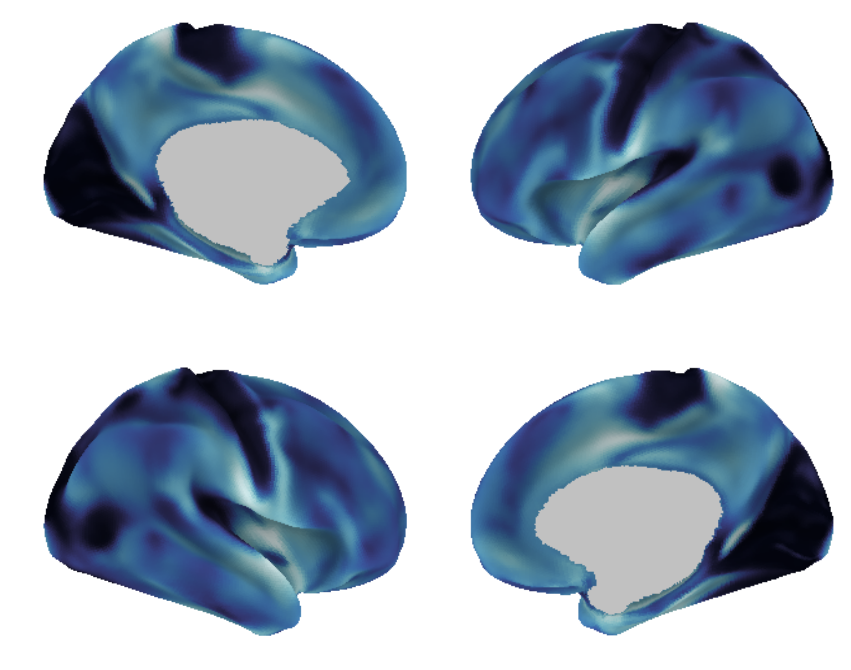

In [165]:
fig=brain_fig(cropped_img)

In [166]:
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_fc_t1_corr.png')

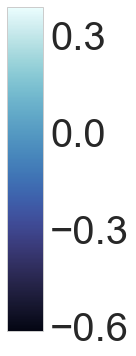

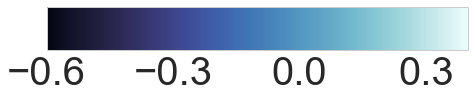

In [171]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cmap = cmocean.cm.ice
norm = mpl.colors.Normalize(vmin=-0.6, vmax=0.4)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='vertical', ticks=[-0.6, -0.3,0,0.3])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_matcorr_cbar.svg')

fig = plt.figure(figsize=(6.5, 4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal', ticks=[-0.6, -0.3,0,0.3])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_matcorr_cbar_horizontal.svg')

sns.set()

### Plot Myelin and FC1

In [106]:
lh_myelin_recort = np.zeros(surfL[0].shape[0])
rh_myelin_recort = np.zeros(surfR[0].shape[0])
lh_myelin_recort[cortL] = myelin[:cortL.shape[0]]
rh_myelin_recort[cortR] = myelin[cortL.shape[0]:]

In [120]:
lh_fc1_recort = np.zeros(surfL[0].shape[0])
rh_fc1_recort = np.zeros(surfR[0].shape[0])
lh_fc1_recort[cortL] = -gradients[:,0][:cortL.shape[0]]
rh_fc1_recort[cortR] = -gradients[:,0][cortL.shape[0]:]

In [142]:
sns.set_context(None)
cropped_img = []
cmap=cmocean.cm.tempo

sns.set_style('white')
for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfL[0], surfL[1], stat_map=lh_myelin_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcL, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False, vmin=1, vmax=1.6)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfR[0], surfR[1], stat_map=rh_myelin_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcR, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False, vmin=1, vmax=1.6)
    cropped_img.append(crop_img(plot))

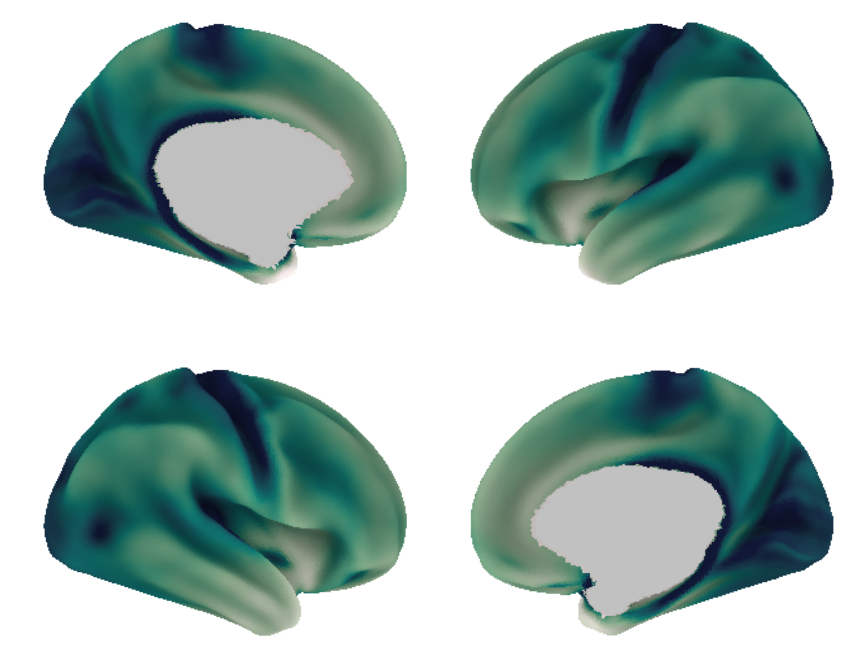

In [143]:
fig = brain_fig(cropped_img)

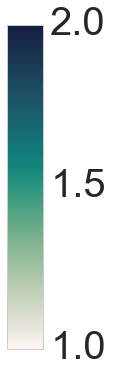

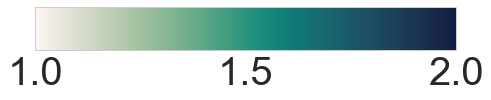

In [170]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cmap = cmocean.cm.tempo
norm = mpl.colors.Normalize(vmin=1, vmax=2)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='vertical', ticks=[1,1.5,2])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_myelin_cbar.svg')

fig = plt.figure(figsize=(6.5, 4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal', ticks=[1,1.5,2])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_myelin_cbar_horizontal.svg')

sns.set()

In [144]:
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_myelin.png')

In [138]:
sns.set_context(None)
cropped_img = []
cmap=cmocean.cm.tempo

sns.set_style('white')
for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfL[0], surfL[1], stat_map=lh_fc1_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcL, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False, vmin=-2.5, vmax=2.5)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(0, 0), (0, 180)]:
    plot=plot_surf_stat_map(surfR[0], surfR[1], stat_map=rh_fc1_recort,
                            cmap=cmap, figsize=(10,8),
                            bg_map=sulcR, bg_on_stat=True,darkness=0.6,
                            elev=elev,azim=azim,threshold=1e-50, 
                            symmetric_cbar=False, vmin=-2.5, vmax=2.5)
    cropped_img.append(crop_img(plot))

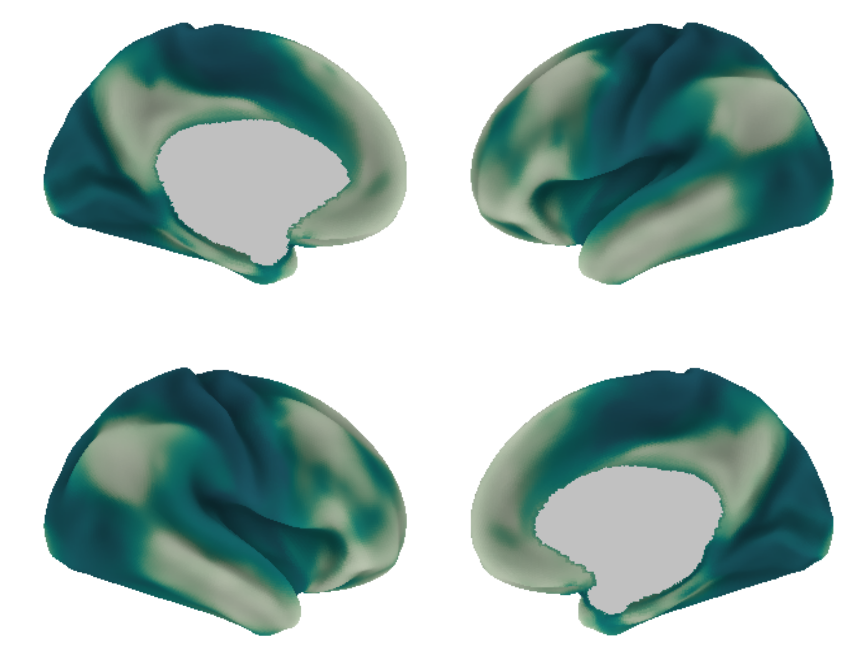

In [139]:
fig = brain_fig(cropped_img)

In [140]:
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_fc1.png')

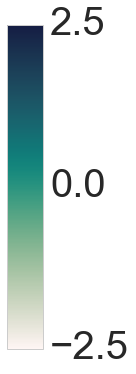

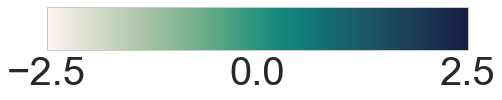

In [168]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cmap = cmocean.cm.tempo
norm = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='vertical', ticks=[-2.5,0,2.5])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_fc1_cbar.svg')

fig = plt.figure(figsize=(6.5, 4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal', ticks=[-2.5,0,2.5])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/hcp_fc1_cbar_horizontal.svg')

sns.set()